In [114]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity,cosine_distances
import math

In [2]:
#metrics for evaluating performance
#https://towardsdatascience.com/evaluation-metrics-for-recommender-systems-df56c6611093
#https://towardsdatascience.com/breaking-down-mean-average-precision-map-ae462f623a52
#http://sdsawtelle.github.io/blog/output/mean-average-precision-MAP-for-recommender-systems.html



## Exploration of the data

In [3]:
base_path = 'C:\\Users\\nicor\\OneDrive\\Documentos\\Python\\Kaggle\\H&M Personalize fashion Recommender system - datasets\\'

### loading csv files into dataframes

In [4]:
#load articles dataset
articles = pd.read_csv(base_path + 'articles.csv')

#load customers dataset
customers = pd.read_csv(base_path + 'customers.csv')

#load transactions dataset
transactions = pd.read_csv(base_path + 'transactions_train.csv')

#load sample submission dataset
sample_submission = pd.read_csv(base_path + 'sample_submission.csv')

### Articles Dataset

In [5]:
#Exploration of the articles dataset
articles.info()
articles.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105542 entries, 0 to 105541
Data columns (total 25 columns):
 #   Column                        Non-Null Count   Dtype 
---  ------                        --------------   ----- 
 0   article_id                    105542 non-null  int64 
 1   product_code                  105542 non-null  int64 
 2   prod_name                     105542 non-null  object
 3   product_type_no               105542 non-null  int64 
 4   product_type_name             105542 non-null  object
 5   product_group_name            105542 non-null  object
 6   graphical_appearance_no       105542 non-null  int64 
 7   graphical_appearance_name     105542 non-null  object
 8   colour_group_code             105542 non-null  int64 
 9   colour_group_name             105542 non-null  object
 10  perceived_colour_value_id     105542 non-null  int64 
 11  perceived_colour_value_name   105542 non-null  object
 12  perceived_colour_master_id    105542 non-null  int64 
 13 

article_id  product_code          prod_name  product_type_no  \
0   108775015        108775          Strap top              253   
1   108775044        108775          Strap top              253   
2   108775051        108775      Strap top (1)              253   
3   110065001        110065  OP T-shirt (Idro)              306   
4   110065002        110065  OP T-shirt (Idro)              306   

  product_type_name  product_group_name  graphical_appearance_no  \
0          Vest top  Garment Upper body                  1010016   
1          Vest top  Garment Upper body                  1010016   
2          Vest top  Garment Upper body                  1010017   
3               Bra           Underwear                  1010016   
4               Bra           Underwear                  1010016   

  graphical_appearance_name  colour_group_code colour_group_name  ...  \
0                     Solid                  9             Black  ...   
1                     Solid                 10             White  ...   
2                    Stripe                 11         Off White  ...   
3                     Solid                  9             Black  ...   
4                     Solid                 10             White  ...   

   department_name index_code        index_name index_group_no  \
0     Jersey Basic          A        Ladieswear              1   
1     Jersey Basic          A        Ladieswear              1   
2     Jersey Basic          A        Ladieswear              1   
3   Clean Lingerie          B  Lingeries/Tights              1   
4   Clean Lingerie          B  Lingeries/Tights              1   

   index_group_name section_no            section_name garment_group_no  \
0        Ladieswear         16  Womens Everyday Basics             1002   
1        Ladieswear         16  Womens Everyday Basics             1002   
2        Ladieswear         16  Womens Everyday Basics             1002   
3        Ladieswear         61         Womens Lingerie             1017   
4        Ladieswear         61         Womens Lingerie             1017   

   garment_group_name                                        detail_desc  
0        Jersey Basic            Jersey top with narrow shoulder straps.  
1        Jersey Basic            Jersey top with narrow shoulder straps.  
2        Jersey Basic            Jersey top with narrow shoulder straps.  
3   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  
4   Under-, Nightwear  Microfibre T-shirt bra with underwired, moulde...  

[5 rows x 25 columns]

In [6]:
#filtering articles dataset
articles_filtered = articles.drop(columns=['graphical_appearance_no',
       'graphical_appearance_name', 'colour_group_code', 'colour_group_name',
       'perceived_colour_value_id', 'perceived_colour_value_name'])


In [7]:
#Exploration of na values in articles dataset
articles_filtered.isnull().sum() #no na values (except for the description...) 

article_id                        0
product_code                      0
prod_name                         0
product_type_no                   0
product_type_name                 0
product_group_name                0
perceived_colour_master_id        0
perceived_colour_master_name      0
department_no                     0
department_name                   0
index_code                        0
index_name                        0
index_group_no                    0
index_group_name                  0
section_no                        0
section_name                      0
garment_group_no                  0
garment_group_name                0
detail_desc                     416
dtype: int64

##### Dictionary of the articles dataset

In [8]:
#creating a dataframe with the article_id and prod_name 
articles_id_name = articles[['article_id' , 'prod_name']].drop_duplicates().reset_index(drop=True)

### Customers dataset

In [9]:
#Exploration of the customers dataset
customers.info()
customers.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1371980 entries, 0 to 1371979
Data columns (total 7 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   customer_id             1371980 non-null  object 
 1   FN                      476930 non-null   float64
 2   Active                  464404 non-null   float64
 3   club_member_status      1365918 non-null  object 
 4   fashion_news_frequency  1355971 non-null  object 
 5   age                     1356119 non-null  float64
 6   postal_code             1371980 non-null  object 
dtypes: float64(3), object(4)
memory usage: 73.3+ MB


customer_id   FN  Active  \
0  00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...  NaN     NaN   
1  0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...  NaN     NaN   
2  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...  NaN     NaN   
3  00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...  NaN     NaN   
4  00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...  1.0     1.0   

  club_member_status fashion_news_frequency   age  \
0             ACTIVE                   NONE  49.0   
1             ACTIVE                   NONE  25.0   
2             ACTIVE                   NONE  24.0   
3             ACTIVE                   NONE  54.0   
4             ACTIVE              Regularly  52.0   

                                         postal_code  
0  52043ee2162cf5aa7ee79974281641c6f11a68d276429a...  
1  2973abc54daa8a5f8ccfe9362140c63247c5eee03f1d93...  
2  64f17e6a330a85798e4998f62d0930d14db8db1c054af6...  
3  5d36574f52495e81f019b680c843c443bd343d5ca5b1c2...  
4  25fa5ddee9aac01b35208d01736e57942317d756b32ddd...

In [10]:
#filtering columns of customers dataset
customers_filtered = customers[['customer_id', 'Active', 'age']]

In [37]:
#how many active customers had a purchase in the dataset

#WIP
customers_filtered.customer_id[customers_filtered.Active.isna() == True].isin(transactions.customer_id.unique()).sum() #all customers have a purchase


0

#### Analysis of NA values

In [11]:
total_entries_c = len(customers_filtered)

#Exploration of na values in customer_id column
print(customers_filtered.customer_id.isna().sum()) #no na values

#Exploration of na values in Active column
print(f'The amount of NA values in the Active col is:{customers_filtered.Active.isna().sum()} ({round(customers_filtered.Active.isna().sum()/total_entries_c*100,2)}%)') 

#Replacing na values in Active column with 0
customers_filtered.Active.fillna(0, inplace=True)

#Exploration of na values in age column
print(f'The amount of NA values in the Active col is:{customers_filtered.age.isna().sum()} ({round(customers_filtered.age.isna().sum()/total_entries_c*100,2)}%)') 

#Replacing na values in age column with the average of the age column
customers_filtered.age.fillna(customers_filtered.age.mean(), inplace=True)

0
The amount of NA values in the Active col is:907576 (66.15%)
The amount of NA values in the Active col is:15861 (1.16%)


C:\Users\nicor\anaconda3\envs\mne3\lib\site-packages\pandas\core\series.py:4536: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


### Transactions dataset

In [12]:
#Exploration of transaction dataset
transactions.info()
transactions.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31788324 entries, 0 to 31788323
Data columns (total 5 columns):
 #   Column            Dtype  
---  ------            -----  
 0   t_dat             object 
 1   customer_id       object 
 2   article_id        int64  
 3   price             float64
 4   sales_channel_id  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 1.2+ GB


t_dat                                        customer_id  article_id  \
0  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   663713001   
1  2018-09-20  000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...   541518023   
2  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   505221004   
3  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687003   
4  2018-09-20  00007d2de826758b65a93dd24ce629ed66842531df6699...   685687004   

      price  sales_channel_id  
0  0.050831                 2  
1  0.030492                 2  
2  0.015237                 2  
3  0.016932                 2  
4  0.016932                 2

#### Analysis of NA values in transactions dataset

In [13]:
#Exploration of na values in transaction dataset
total_entries_t = len(transactions)

for item in transactions.columns: #no na values! 
    print(f'The amount of NA values in the {item} column is:{transactions[item].isna().sum()} ({round(transactions[item].isna().sum()/total_entries_t*100,2)}%)')

The amount of NA values in the t_dat column is:0 (0.0%)
The amount of NA values in the customer_id column is:0 (0.0%)
The amount of NA values in the article_id column is:0 (0.0%)
The amount of NA values in the price column is:0 (0.0%)
The amount of NA values in the sales_channel_id column is:0 (0.0%)


### Purchase frequency

In [14]:
#Exploring if a same customer bought the same article more than once
purchase_freq = transactions.groupby(['customer_id', 'article_id']).size().reset_index(name='count')

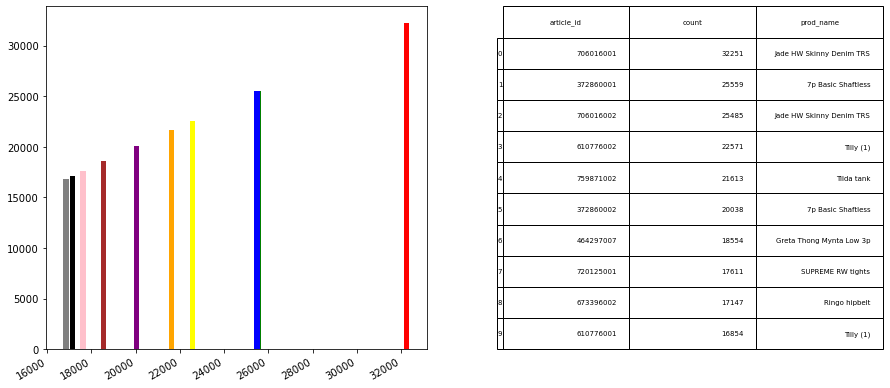

In [15]:
#plot the frequency of purchases of the top 10 most purchased articles
purchase_freq_top10 = purchase_freq.groupby('article_id').size().reset_index(name='count')
purchase_freq_top10 = purchase_freq_top10.sort_values(by='count', ascending=False).head(10)

#merge the name of the products to the dataframe
purchase_freq_top10 = purchase_freq_top10.merge(articles_id_name, left_on='article_id', right_on='article_id')

#plot into a graph the frequency of purchases of the top 10 most purchased articles
top10_art = purchase_freq_top10['prod_name']
top10_count = purchase_freq_top10['count']

#final adjustments pending



fig = plt.figure(figsize=[15,7])
ax1 = fig.add_subplot(121)
ax1.bar(top10_count, top10_count, width=250,color=['red', 'green', 'blue', 'yellow', 'orange', 'purple', 'brown', 'pink', 'black', 'grey'])
fig.autofmt_xdate()
ax2 = fig.add_subplot(122)
font_size = 40
bbox = [0, 0, 1, 1]
ax2.axis('off')
mpl_table = ax2.table(cellText=purchase_freq_top10.values, rowLabels=purchase_freq_top10.index, bbox=bbox, colLabels=purchase_freq_top10.columns)
plt.show()

## Clustering
Clustering according to the age of the customer

In [16]:
#Clustering of the age column

#k means clustering
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

label = KMeans(n_clusters=5, random_state=0).fit(customers_filtered.age.values.reshape(-1,1))
labels = label.predict(customers_filtered.age.values.reshape(-1,1))


The amount of customers in cluster 0 is 204606 being the center located at 21 years
The amount of customers in cluster 1 is 412158 being the center located at 29 years
The amount of customers in cluster 2 is 311395 being the center located at 39 years
The amount of customers in cluster 3 is 338303 being the center located at 51 years
The amount of customers in cluster 4 is 105518 being the center located at 64 years


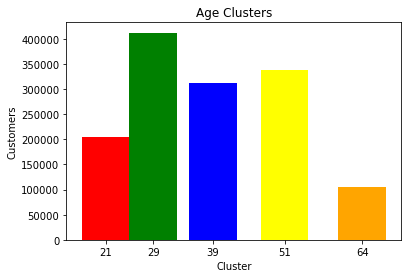

In [17]:
#calculating how many customers are in each cluster
cluster_count = pd.DataFrame(labels, columns=['cluster'])
cluster_count = cluster_count.groupby('cluster').size().reset_index(name='count')

#calculating the cluster centers
plot_age_cluster = pd.DataFrame(label.cluster_centers_, columns=['age_cluster'])
plot_age_cluster['age_cluster'] = plot_age_cluster['age_cluster'].astype(int).sort_values().reset_index(drop=True)

plot_age_cluster.index.name = 'cluster'

#merge the dataframes
plot_age_cluster = pd.merge(plot_age_cluster, cluster_count, on='cluster')

for i in plot_age_cluster['cluster'].unique():
    print(f'The amount of customers in cluster {i} is {plot_age_cluster.loc[i, "count"]} being the center located at {plot_age_cluster.loc[i, "age_cluster"]} years')

#plotting the clusters
x = plot_age_cluster['age_cluster']
y = plot_age_cluster.loc[:, 'count']

#plot the clusters with multiple colors
plt.bar(x, y, color=['red', 'green', 'blue', 'yellow', 'orange'],label = plot_age_cluster['age_cluster'], width= 8)
plt.xticks(plot_age_cluster['age_cluster'], plot_age_cluster['age_cluster'])
plt.xlabel('Cluster')
plt.ylabel('Customers')
plt.title('Age Clusters')
plt.show()    

In [18]:
#merge the cluster of the age column to the customers dataset
customers_filtered = customers_filtered.merge(plot_age_cluster, left_on='age', right_on='age_cluster')

C:\Users\nicor\anaconda3\envs\mne3\lib\site-packages\pandas\core\reshape\merge.py:1117: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  UserWarning,


### Labeling the articles dataset with the age clusters

In [19]:
age_to_articles = articles_filtered[['article_id','index_name']]

transactions_aux = transactions[['customer_id','article_id']]

customers_aux = customers_filtered[['customer_id','age']]

transactions_aux = transactions_aux.merge(customers_aux, left_on='customer_id', right_on='customer_id')

transactions_aux

customer_id  article_id   age
0        00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   688873012  29.0
1        00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   501323011  29.0
2        00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   598859003  29.0
3        00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   688873020  29.0
4        00083cda041544b2fbb0e0d2905ad17da7cf1007526fb4...   688873011  29.0
...                                                    ...         ...   ...
3496582  fdfd55a82781e51b05301b269fc91dfab6cf048f0e29e5...   776850001  21.0
3496583  fece2f68864c311a0b5208e2eb735b3dcde7e41461d327...   756322001  21.0
3496584  fece2f68864c311a0b5208e2eb735b3dcde7e41461d327...   822311012  21.0
3496585  fece2f68864c311a0b5208e2eb735b3dcde7e41461d327...   891763003  21.0
3496586  fece2f68864c311a0b5208e2eb735b3dcde7e41461d327...   889133001  21.0

[3496587 rows x 3 columns]

In [20]:
transactions_aux = transactions_aux.groupby(['article_id']).agg({'age':'mean'}).sort_values(by='age', ascending=False)

age_to_articles = age_to_articles.merge(transactions_aux, left_on='article_id', right_on='article_id')

age_to_articles

article_id        index_name        age
0       108775015        Ladieswear  32.862369
1       108775044        Ladieswear  34.055714
2       108775051        Ladieswear  28.538462
3       110065001  Lingeries/Tights  35.750000
4       110065002  Lingeries/Tights  35.442308
...           ...               ...        ...
85768   949551002           Divided  28.000000
85769   952267001  Lingeries/Tights  45.000000
85770   953450001          Menswear  29.000000
85771   953763001        Ladieswear  51.000000
85772   956217002        Ladieswear  51.000000

[85773 rows x 3 columns]

In [21]:
#label the age column based on the distance to the plot_age_cluster cluster centers
age_to_articles['age_cluster'] = age_to_articles['age'].apply(
    lambda x: 1 if x < plot_age_cluster.loc[0, 'age_cluster'] 
    else 2 if x < plot_age_cluster.loc[1, 'age_cluster'] 
    else 3 if x < plot_age_cluster.loc[2, 'age_cluster'] 
    else 4 if x < plot_age_cluster.loc[3, 'age_cluster'] 
    else 5)

In [22]:
age_to_articles_merge = age_to_articles.drop(columns=['index_name'])

In [23]:
age_to_articles_merge

article_id        age  age_cluster
0       108775015  32.862369            3
1       108775044  34.055714            3
2       108775051  28.538462            2
3       110065001  35.750000            3
4       110065002  35.442308            3
...           ...        ...          ...
85768   949551002  28.000000            2
85769   952267001  45.000000            4
85770   953450001  29.000000            3
85771   953763001  51.000000            5
85772   956217002  51.000000            5

[85773 rows x 3 columns]

In [24]:
#merge the age_cluster column from age_to_articles to the articles dataset
articles_filtered = articles_filtered.merge(age_to_articles_merge, left_on='article_id', right_on='article_id', how='left')

In [25]:
articles_filtered.rename(columns={'age':'mean_purchase_age'}, inplace=True)

#### Assign an average age purchase to the not purchased articles
There are customers that did not purchase anything so there will be NaN values in the articles dataset

In [41]:
art_no_purchase = articles_filtered[articles_filtered.age_cluster.isnull() == True].shape[0]
art_w_purchase = articles_filtered[articles_filtered.age_cluster.isnull() == False].shape[0]

print(f'There are {art_no_purchase} articles without a purchase and {art_w_purchase} articles with at least one purchase')

There are 19769 articles without a purchase and 85773 articles with at least purchase


In [102]:
#view the gross categories for the articles
print(articles_filtered.index_group_name.unique())

['Ladieswear' 'Baby/Children' 'Menswear' 'Sport' 'Divided']


In [70]:
#filter the NaN values from the mean_purchase_age column
articles_filtered_no_na = articles_filtered[articles_filtered.mean_purchase_age.isnull() == False]

#take the average purchase age of each index group name
index_group_age_mean = articles_filtered_no_na[['index_group_name','mean_purchase_age']].groupby(
    'index_group_name').mean().reset_index()

index_group_age_mean

index_group_name  mean_purchase_age
0    Baby/Children          37.235240
1          Divided          31.951539
2       Ladieswear          34.433889
3         Menswear          36.062697
4            Sport          36.322701

In [82]:
#merge the index group name and mean purchase age to the articles dataset
articles_filtered_2 = articles_filtered.merge(index_group_age_mean , how = 'left', left_on = 'index_group_name', right_on = 'index_group_name')


In [100]:
#select the definitive average age of the customer
articles_filtered_2['mean_purchase_age_def'] = articles_filtered_2[['mean_purchase_age_x','mean_purchase_age_y']].apply(
    lambda x: x['mean_purchase_age_y'] 
    if np.isnan(x['mean_purchase_age_x']) 
    else x['mean_purchase_age_x'], axis=1)

In [104]:
articles_filtered_2.drop(columns=['mean_purchase_age_x','mean_purchase_age_y'], inplace=True)

In [107]:
articles_filtered_2['mean_purchase_age_def'] = round(articles_filtered_2['mean_purchase_age_def'],2)

In [127]:
#fill the nan values of the age_cluster column based on the distance to the plot_age_cluster cluster centers

def fillna_age_cluster(x):
    if math.isnan(x) == True:
        if x < plot_age_cluster.loc[0, 'age_cluster']:
            return 1
        elif x < plot_age_cluster.loc[1, 'age_cluster']:
            return 2
        elif x < plot_age_cluster.loc[2, 'age_cluster']:
            return 3
        elif x < plot_age_cluster.loc[3, 'age_cluster']:
            return 4
        else:
            return 5
    else:
        return x

articles_filtered_2['age_cluster'] = articles_filtered_2['age_cluster'].map(fillna_age_cluster)

## User based Collaborative Filtering

In [27]:
from sklearn import preprocessing

#create a function to build a collabortive filtering recommender system
def get_recommendations(customer_id, articles_id_name, transactions, articles, customers, k=5):
    #get the customer's cluster
    customer_cluster = customers_filtered.loc[customers_filtered['customer_id'] == customer_id, 'cluster'].values[0]
    
    #get the articles for that cluster
    cluster_articles = articles_filtered.loc[articles_filtered['age_cluster'] == customer_cluster]
    
    #get the transactions of the customer
    customer_transactions = transactions.loc[transactions['customer_id'] == customer_id]
    
    #get the articles the customer has already bought
    customer_articles = customer_transactions['article_id']
    
    # REVIEW FROM THIS POINT FORWARD
    #------------------------------------------------------
    #get the articles that are in the cluster but the customer has not bought yet
    cluster_articles = cluster_articles.loc[~cluster_articles['article_id'].isin(customer_articles)]
    
    #get the similarity score for each article in the cluster
    similarity_scores = []
    for article in cluster_articles['article_id']:
        similarity_scores.append((article, 
        cosine_similarity(articles_filtered.loc[articles_filtered['article_id'] == article, 'article_vector'].values[0], 
        articles.loc[articles['article_id'] == customer_articles.values[0], 'article_vector'].values[0])[0][0]))
    
    #sort the articles based on the similarity scores
    similarity_scores = sorted(similarity_scores, key=lambda x: x[1], reverse=True)
    
    #get the k most similar articles to the customer
    article_list = []
    for i in range(k):
        article_list.append(similarity_scores[i][0])
    
    #get the titles of the k most similar articles
    article_list_names = []
    for i in article_list:
        article_list_names.append(articles_id_name.loc[articles_id_name['article_id'] == i, 'prod_name'].values[0])
    
    #return the titles of the k most similar articles
    return article_list_names

In [28]:
#### Testing blocks of the function

In [29]:
#get the customer's cluster
customer_cluster = customers_filtered.loc[customers_filtered['customer_id'] == '0000945f66de1a11d9447609b8b41b1bc987ba185a5496ae8831e8493afa24ff', 'cluster'].values[0]

#get the articles for that cluster
cluster_articles = articles_filtered.loc[articles_filtered['age_cluster'] == customer_cluster]


In [30]:
#get the transactions of the customer
customer_transactions = transactions.loc[transactions['customer_id'] == 'be1981ab818cf4ef6765b2ecaea7a2cbf14ccd6e8a7ee985513d9e8e53c6d91b']

#get the articles the customer has already bought
customer_articles = customer_transactions['article_id']
    

In [31]:
cluster_articles = cluster_articles.loc[~cluster_articles['article_id'].isin(customer_articles)]

In [32]:
#get the similarity score for each article in the cluster
similarity_scores = []
for article in cluster_articles['article_id']:
    similarity_scores.append((article,
    cosine_similarity(articles_filtered.loc[articles_filtered['article_id'] == article, 'article_vector'].values[0],
    articles.loc[articles['article_id'] == customer_articles.values[0], 'article_vector'].values[0])[0][0]))